# METEO DATA PREPARATION AND FIRST VISUALIZATION

This Jupyter Notebook is meant to prepare and visualize the data in alignment with the paper "Neural Networks for Extreme Quantile Regression with an Application to Forecasting of Flood Risk by Olivier Pasche and Sebastian Engelke". The goal is to apply the algorithm to the same dataset and split used in the paper for a matter of comparison in the result.

The study uses the daily discharge at Bern-Schönau Station (#62) as the response variable. As regressors, it includes daily precipitation from various locations in the canton of Bern (BEP, GHS, THU, LTB, BRZ, MER), along with the daily discharge at the Gsteig Station (#43).

For visualization purposes, the topographic map of the water catchment, showing both gauging stations along with the six meteorological stations used for precipitation measurement, is provided below. This map was originally developed by Olivier Pasche in the paper mentioned before.

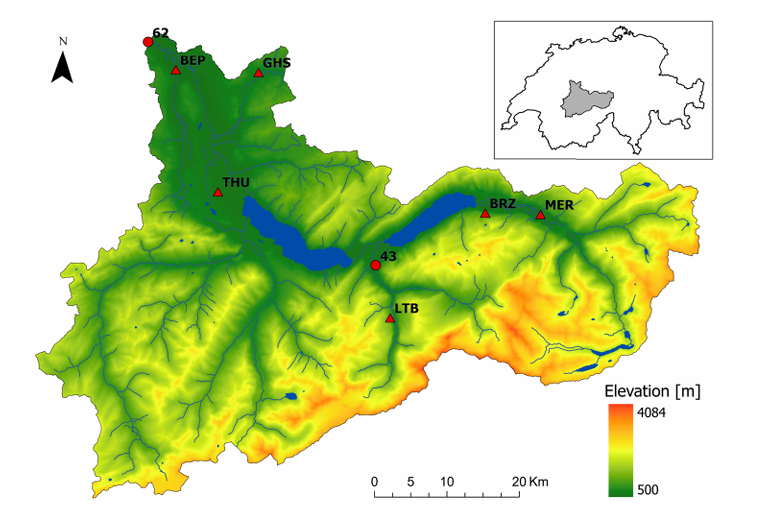

In [1]:
from IPython.display import Image
Image(filename='Topographic_map.png') 

## 0. Import Package:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from matplotlib.dates import AutoDateLocator, YearLocator


# Set current and repository working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


from Modules.Data_Preparation import *

## 01. Preparation Data

As previously explained, we will use data from 1930 onward for the two stations (Bern-Schönau and Gsteig) from the *Discharges_all* dataset, along with precipitation data from multiple meteorological stations in the *precip.csv* dataset.

### <u>Import data:</u>

In [3]:
# Import discharge dataset
discharge_raw = pd.read_csv("Discharges_all.csv", parse_dates=[0], index_col=0)
discharge_raw.index.name = "Date"
discharge = discharge_raw.loc["1930-01-01":]
discharge.head(2)

station_1  station_2  station_3  station_4  station_5  station_6  \
Date                                                                           
1930-01-01        NaN        NaN        NaN        NaN        NaN       3.57   
1930-01-02        NaN        NaN        NaN        NaN        NaN       3.20   

            station_7  station_8  station_9  station_10  ...  station_59  \
Date                                                     ...               
1930-01-01        NaN       4.44        NaN         NaN  ...        39.9   
1930-01-02        NaN       4.61        NaN         NaN  ...        36.2   

            station_60  station_61  station_62  station_63  station_64  \
Date                                                                     
1930-01-01         NaN        32.2        46.1        67.3        74.0   
1930-01-02         NaN        35.4        46.1        65.5        72.5   

            station_65  station_66  station_67  station_68  
Date                                                        
1930-01-01        32.3        78.9         NaN         NaN  
1930-01-02        31.8        74.6         NaN         NaN  

[2 rows x 68 columns]

In [4]:
# Import precipitation dataset
precipitation = pd.read_csv("precip.csv", parse_dates=[0], index_col=0)
precipitation.index.name = "Date"
precipitation.head(2)

AIE  AIR  GOS  ALT  ANT  THU  BER   BRW  WIT  CDF  ...  MDO  PAV  \
Date                                                           ...             
1930-01-01  0.4  0.0  0.0  0.4  0.9  0.0  0.0   4.8  6.6  1.5  ...  2.0  0.0   
1930-01-02  3.4  0.0  0.6  1.9  2.8  2.3  4.4  16.6  4.8  8.3  ...  2.4  4.4   

            LUN  SRN  BAM  BUE  DIT  UST  GIN  KUE  
Date                                                
1930-01-01  1.8  1.3  1.6  4.4  5.7  1.8  3.7  1.2  
1930-01-02  9.5  0.5  4.4  5.1  6.4  5.8  4.4  4.2  

[2 rows x 105 columns]

### <u>Filtering data</u>

We will extract the response variable, which is the **daily average discharge at the Bern–Schönau gauging station on the Aare River in Switzerland**. The covariates $X$ include **discharge at the upstream station Gsteig** and **daily precipitation measurements from six locations in the same catchment (BEP, GHS, THU, LTB, BRZ, MER).** The variable abbreviations follow standard hydrology conventions, where Q represents discharge and P represents precipitation.

$\tilde{X}$ represents the combination of all covariates along with the response variable. Its structure will later be used to construct the lagged dataframe.


In [5]:
Schonau_Q = discharge["station_62"].rename("Schonau_Q")
Gsteig_Q = discharge["station_43"].rename("Gsteig_Q")
multi_P = precipitation[["BEP","GHS","THU","LTB", "BRZ", "MER"]]
tilde_X = pd.concat([Gsteig_Q,multi_P,Schonau_Q],axis=1)
tilde_X.head(2)

Gsteig_Q  BEP  GHS  THU  LTB  BRZ  MER  Schonau_Q
Date                                                         
1930-01-01       3.6  0.0  0.0  0.0  0.8  1.3  0.5       46.1
1930-01-02       3.6  3.2  0.5  2.3  1.0  3.4  3.2       46.1

<u>**Check the matching date of collected observations**</u>

To ensure that the dates match across both dataframes, we compare their date indices and check for consistency.

In [6]:
print(discharge.shape)
print(precipitation.shape)
print((discharge.index == precipitation.index).all())

(31046, 68)
(31046, 105)
True


### <u> Data Structure and Summary Statistics </u>

In [7]:
# Check information about the dataset
print(tilde_X.info())

print('\n'+'_'*80)
print('_'*80 + '\n')

# Check statistics of the dataset
print(tilde_X.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31046 entries, 1930-01-01 to 2014-12-31
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Gsteig_Q   31046 non-null  float64
 1   BEP        31046 non-null  float64
 2   GHS        31046 non-null  float64
 3   THU        31046 non-null  float64
 4   LTB        31046 non-null  float64
 5   BRZ        31046 non-null  float64
 6   MER        31046 non-null  float64
 7   Schonau_Q  31046 non-null  float64
dtypes: float64(8)
memory usage: 2.1 MB
None

________________________________________________________________________________
________________________________________________________________________________

           Gsteig_Q           BEP           GHS           THU           LTB  \
count  31046.000000  31046.000000  31046.000000  31046.000000  31046.000000   
mean      18.766328      3.066511      3.416353      2.525533      3.299604   
std       17.405667      6.41

In [8]:
### <u> Export Dataframe </u>
# tilde_X.to_csv('tilde_X.csv')

### <u>Pairplot of the covariates in respect to the response:</u>

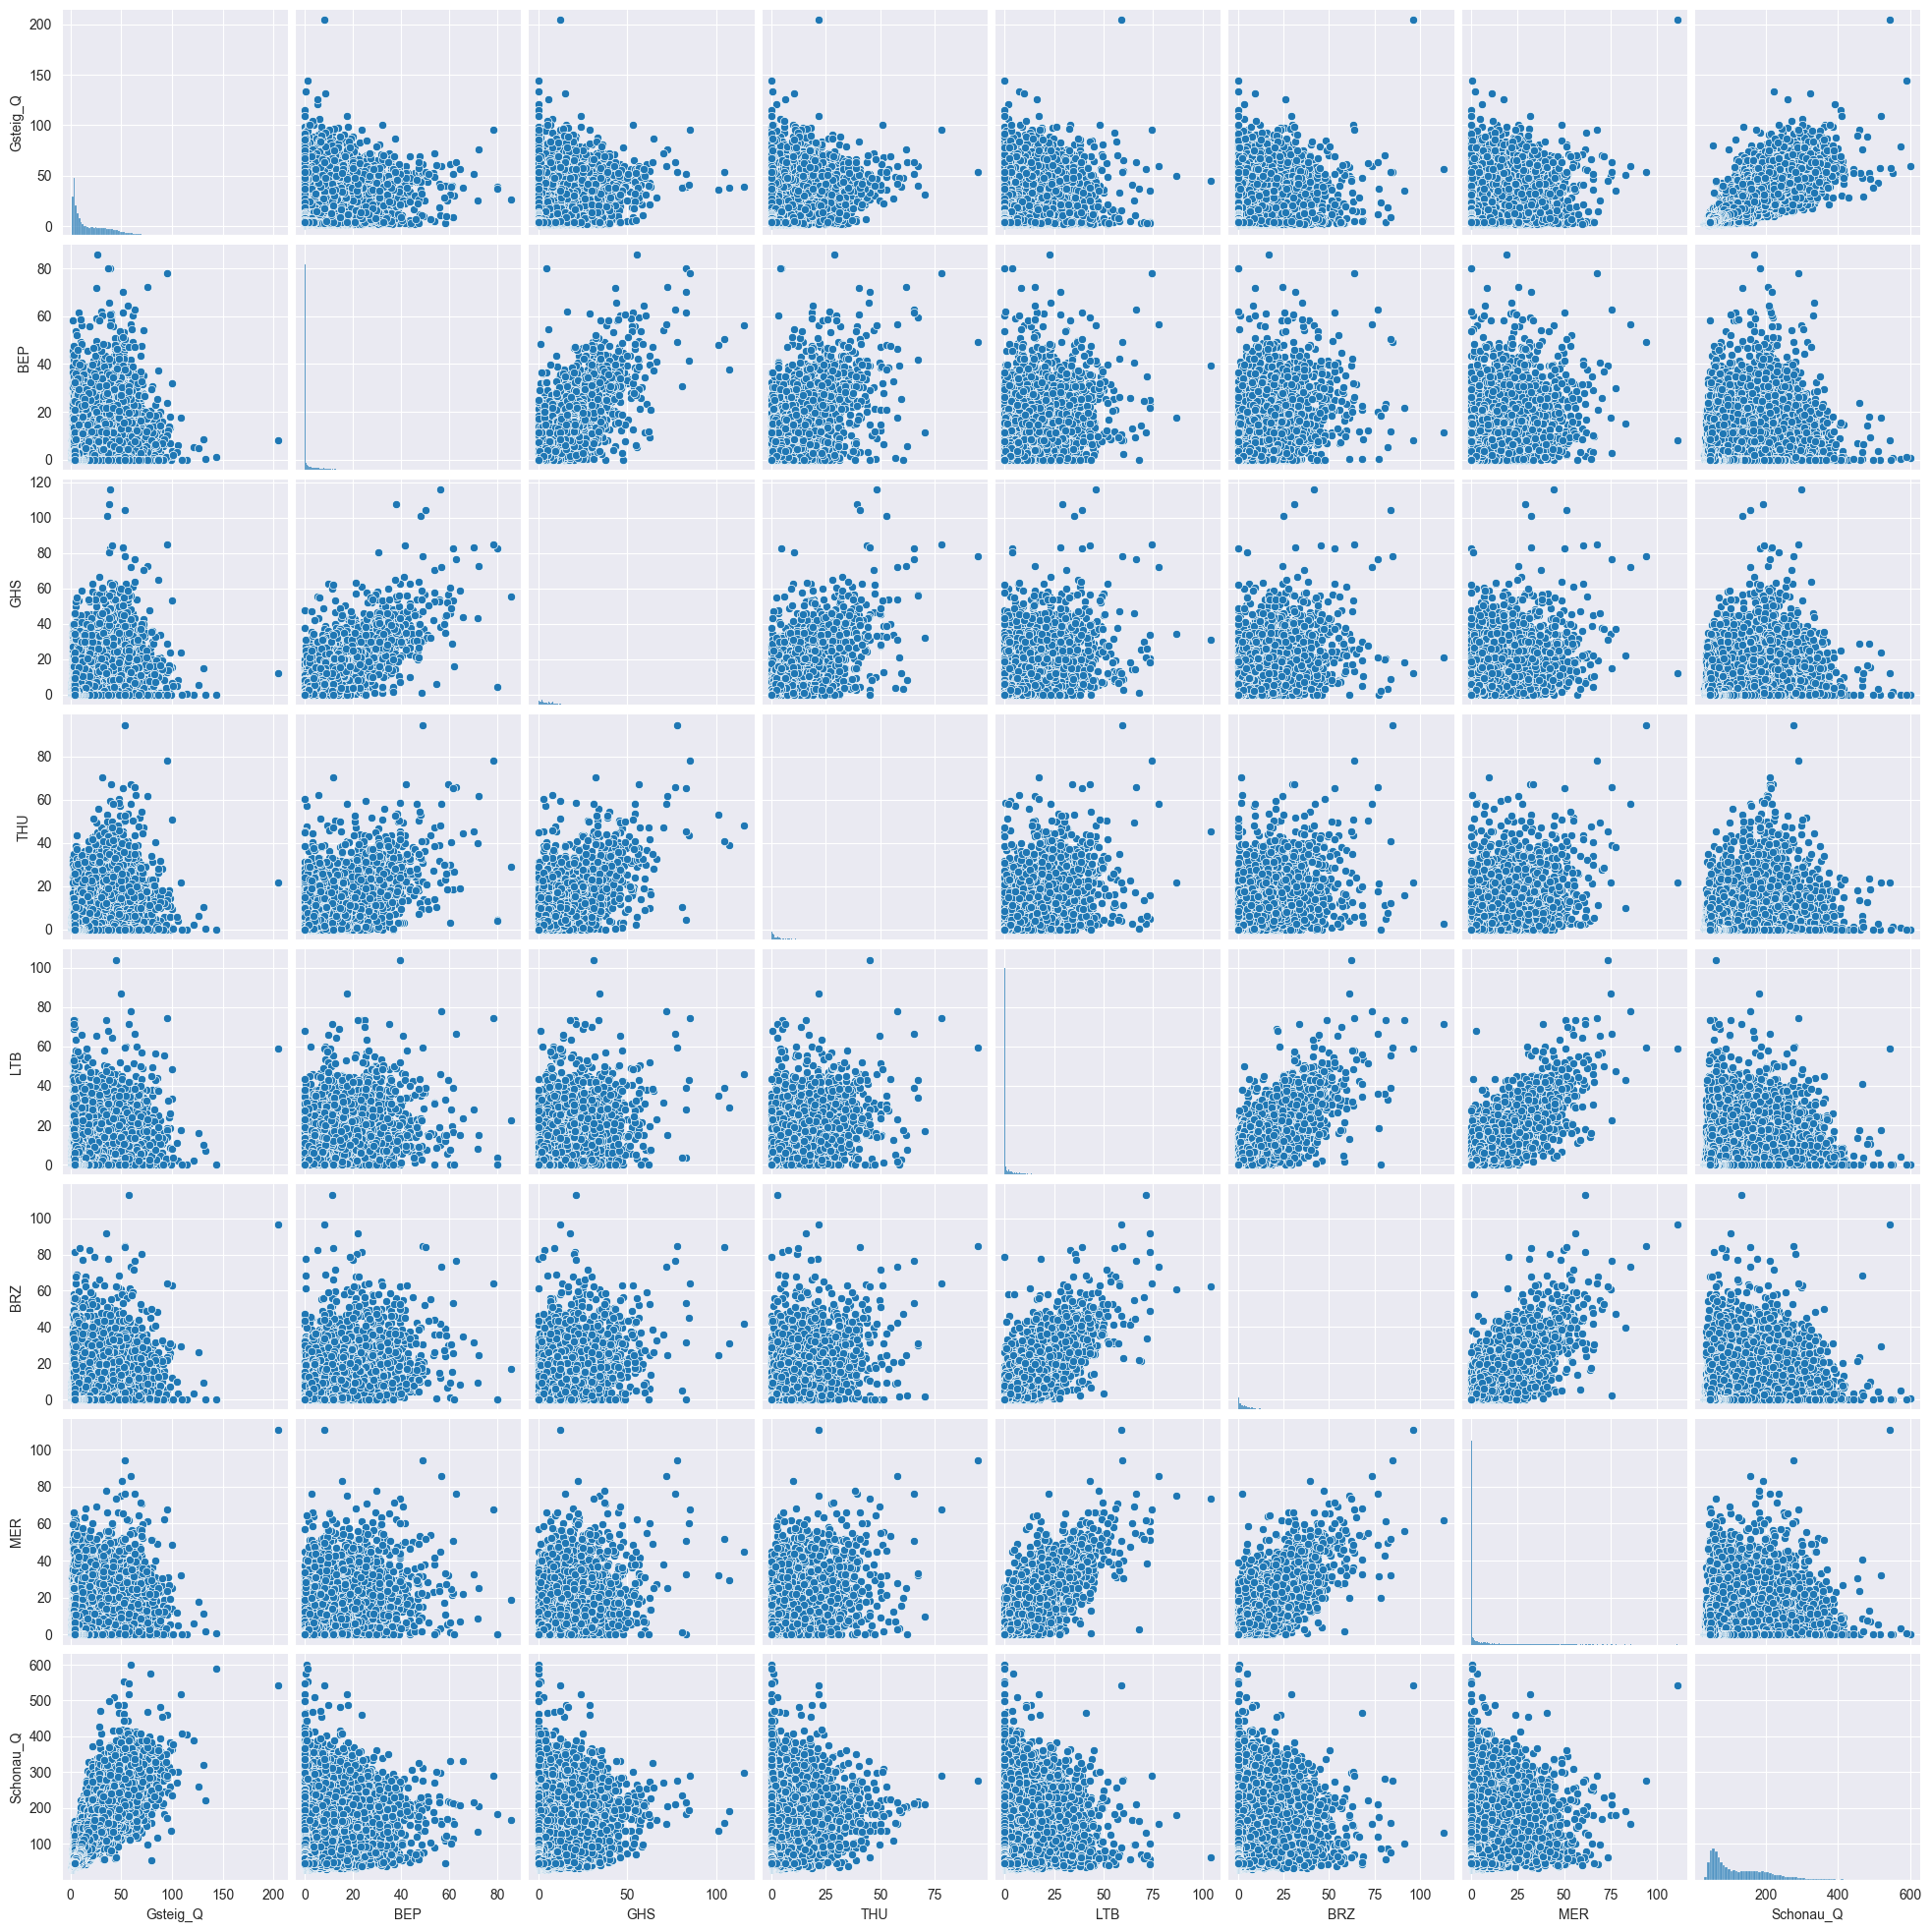

In [9]:
# Plot scatterplot matrix with Schonau_Q being our response variable
sns.set_style('darkgrid')
sns.pairplot(tilde_X)

### <u>Construction Lagged Daframe</u>
Using $\tilde{X} = (x_t, y_t)$, we construct a lagged DataFrame that contains shifted versions of the data with a lag of 10 time steps, following the notation:
    $$
    \tilde{\mathbf{x}}_t = \left\{ (\mathbf{x}_j, y_j) \right\}_{j=t-s}^{t-1} , \quad \text{with } s = 10
    $$

Finally, we concatenate the original response variable to the dataset for prediction and remove any unnecessary rows generated due to shifting.

The function `create_lagged_features` is provided in the module `Data_Preparation.py` within the *modules* folder, which will be used later for practical implementation in other simulations.



In [10]:
import Modules.Data_Preparation as dp

In [11]:
# Define length sequence
seq_length = 10

# Build sequence \Tilde[X_t} concatenated with y
lag_X__Y  = dp.create_lagged_features(tilde_X, lags=seq_length)
lag_X__Y.head(2)

Gsteig_Q_lag_1  BEP_lag_1  GHS_lag_1  THU_lag_1  LTB_lag_1  \
Date                                                                     
1930-01-11            2.97        0.0        0.0        0.0        0.3   
1930-01-12            2.89        6.6        5.2        5.3        8.1   

            BRZ_lag_1  MER_lag_1  Schonau_Q_lag_1  Gsteig_Q_lag_2  BEP_lag_2  \
Date                                                                           
1930-01-11        0.0        0.0             61.5            3.14        4.2   
1930-01-12       11.6        4.2             52.3            2.97        0.0   

            ...  Schonau_Q_lag_9  Gsteig_Q_lag_10  BEP_lag_10  GHS_lag_10  \
Date        ...                                                             
1930-01-11  ...             46.1              3.6         0.0         0.0   
1930-01-12  ...             67.8              3.6         3.2         0.5   

            THU_lag_10  LTB_lag_10  BRZ_lag_10  MER_lag_10  Schonau_Q_lag_10  \
Date                                                                           
1930-01-11         0.0         0.8         1.3         0.5              46.1   
1930-01-12         2.3         1.0         3.4         3.2              46.1   

            Schonau_Q  
Date                   
1930-01-11       52.3  
1930-01-12       40.6  

[2 rows x 81 columns]

### <u>Pair Plot of Different Lags with Respect to Y</u>

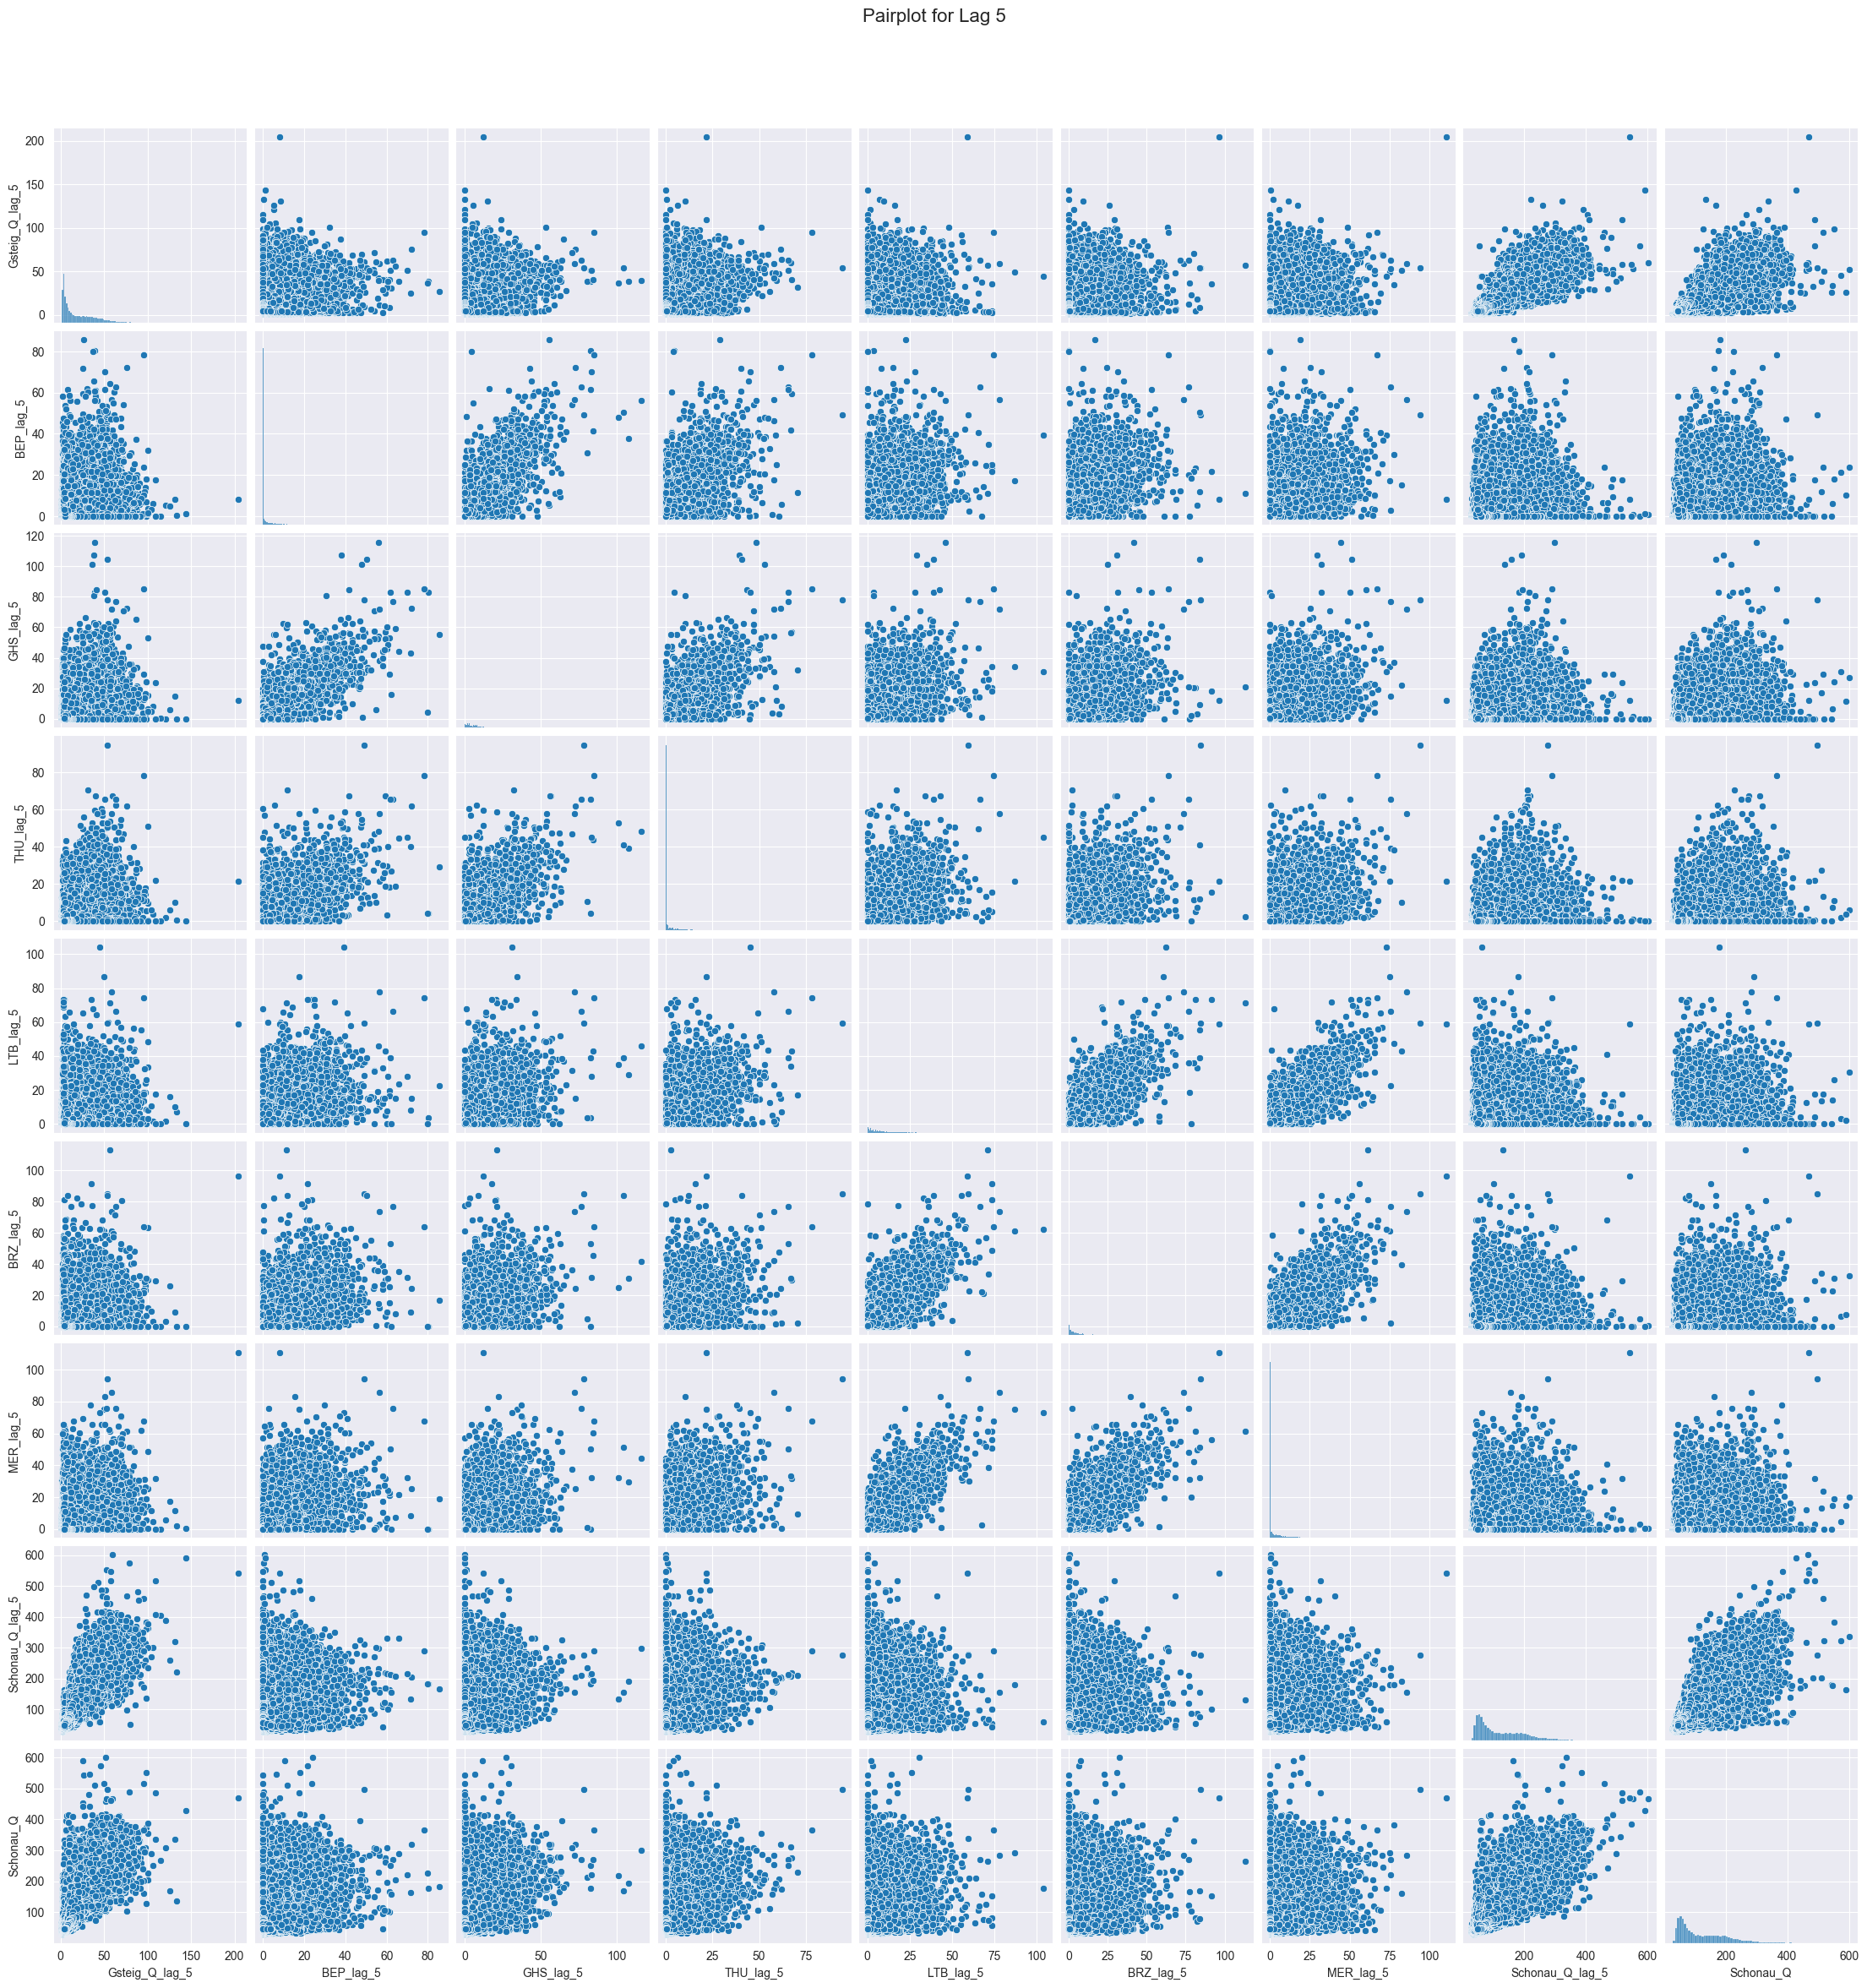

In [12]:
# Pairplot for each lag (Adjust to seq_length+1 to visualize all of them)

for lag in range(5,6):
    select_columns = [f"{col}_lag_{lag}" for col in tilde_X.columns]
    lag_df = lag_X__Y[select_columns].copy()
    lag_df_XY = lag_df.join(Schonau_Q, how="inner")
    plts = sns.pairplot(lag_df_XY)
    plts.fig.suptitle(f"Pairplot for Lag {lag}", y=1.05, fontsize=16)
    plt.show()

## 02. Time Series Analysis



### <u>ACF And PACF Of The Response Variable</u>

To justify the choice of the sequence length in terms of lag, we can plot the ACF and PACF of the response variable. This allows us to observe the autoregressive properties and the overall temporal dependence structure of the series, helping to identify how many past observations influence the current value.

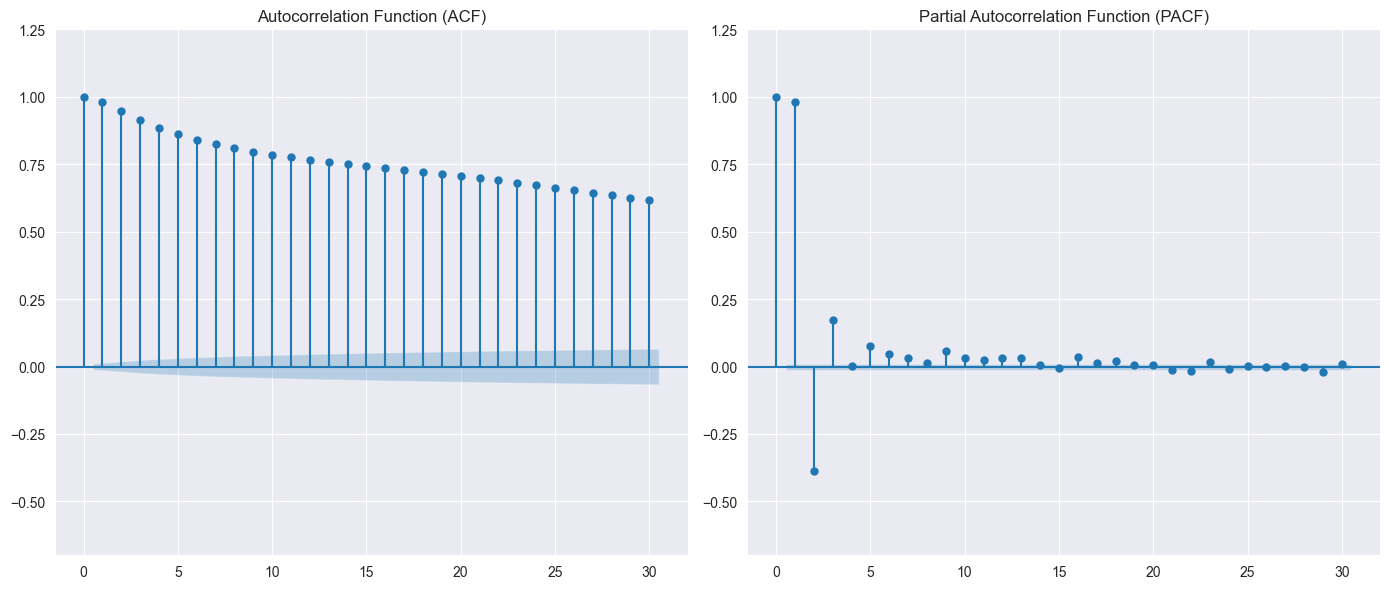

In [13]:
# Extract the response variable (Schonau_Q) from the lag_X__Y dataframe
Y_ACFPACF = tilde_X['Schonau_Q']

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ACF plot
sm.graphics.tsa.plot_acf(Y_ACFPACF, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_ylim(-0.7, 1.25)

# PACF plot
sm.graphics.tsa.plot_pacf(Y_ACFPACF, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_ylim(-0.7, 1.25)

plt.tight_layout()
plt.show()

**Comment:**

The slow decay in ACF and the sharp cutoff in PACF suggest a long term process with strong temporal dependence, aligning with Pasche's findings on potential trend persistence and sequential dependence in the data. To address this, we will not artificially impose stationarity using classical time series methods, as we believe that seasonality and other trends in the response variable can be effectively captured through the covariates.

While the PACF suggests that dependence weakens beyond lag 3, we will still consider a longer sequence. This will allow us to empirically evaluate whether incorporating sequential dependence through an SML provides any added value compared to an MLP, or if the short-term dependencies can already be sufficiently captured without a sequential structure.

### <u>Time Series Plot Of The Whole Series</u>

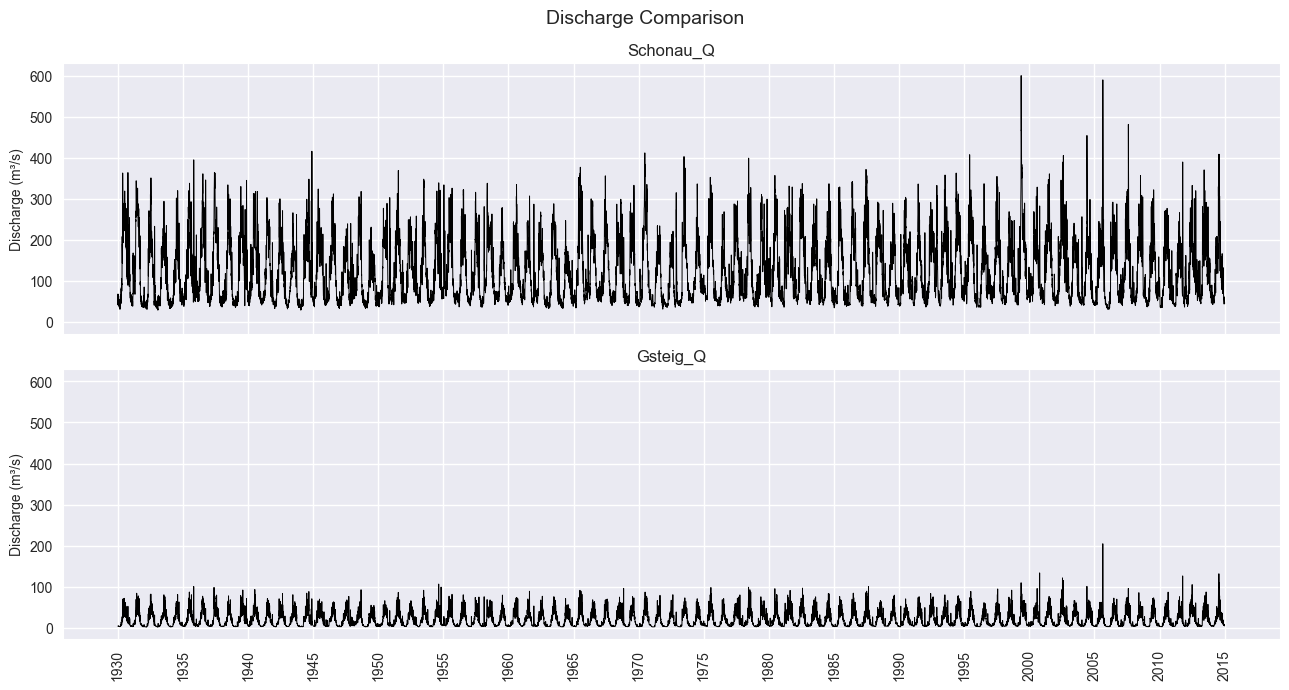

In [14]:
# Extract single variables
discharge_schonau = tilde_X['Schonau_Q']
discharge_gsteig = tilde_X['Gsteig_Q']
dates = tilde_X.index

# Plot Discharge (1x2) with black lines
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True, sharey=True)

# Schonau Discharge
axes[0].plot(dates, discharge_schonau, color="black", linewidth=0.7)
axes[0].set_title("Schonau_Q", fontsize=12)
axes[0].set_ylabel("Discharge (m³/s)")
axes[0].grid(True, linestyle="-", alpha=1, linewidth=1)  

# Gsteig Discharge
axes[1].plot(dates, discharge_gsteig, color="black", linewidth=0.7)
axes[1].set_title("Gsteig_Q", fontsize=12)
axes[1].set_ylabel("Discharge (m³/s)")
axes[1].grid(True, linestyle="-", alpha=1, linewidth=1)  

# Formatting X-axis
axes[1].xaxis.set_major_locator(mdates.YearLocator(base=5))  
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=90)


plt.suptitle("Discharge Comparison", fontsize=14)
plt.tight_layout()
plt.show()



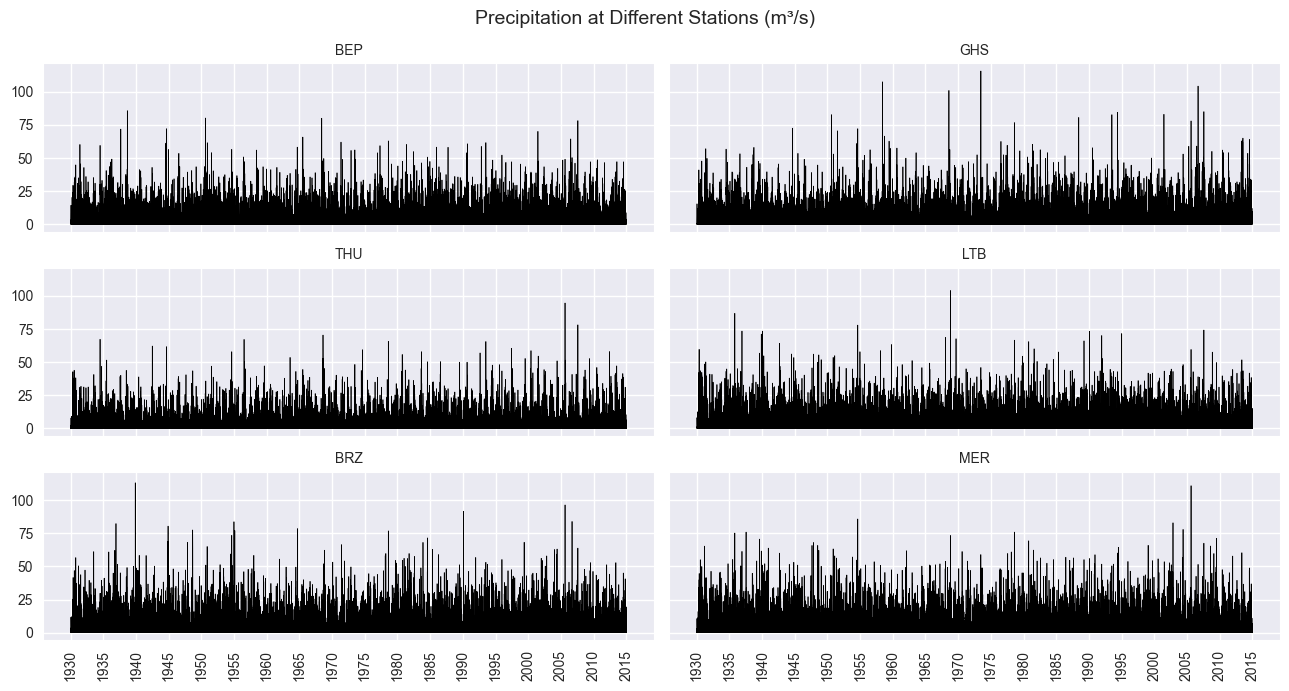

In [15]:
# Plot Precipitation (2x3) 
fig, axes = plt.subplots(3, 2, figsize=(13, 7), sharex=True, sharey=True)

for ax, station in zip(axes.flatten(), multi_P.columns):
    ax.plot(dates, multi_P[station], color='black', linewidth=0.5)
    ax.set_title(station, fontsize=10)
    ax.grid(True, linestyle="-", alpha=1, linewidth=1)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.suptitle("Precipitation at Different Stations (m³/s)", fontsize=14)
plt.tight_layout()
plt.show()


### <u>Time Series Plot Around the Two Highest Discharges in Bern-Schönau</u>

To justify the use of lagged covariates, we identify the two highest peaks in the daily discharge at Schönau Station and extract time series intervals spanning 30 observations before and 10 after each peak. This allows us to analyze how the lagged features evolved during these extreme events.

In [16]:
# Sort dataframe by 'Schonau_Q' in descending order
sorted_tilde_X = tilde_X.sort_values('Schonau_Q', ascending=False)
print(sorted_tilde_X.head(4))

# Extract the date index of the two highest discharge records
highest_records_idx = [tilde_X.index.get_loc(date) for date in sorted_tilde_X.index[:2]]

# Set interval of interest around the index
n_before = 30
n_after = 10

# Extract the subsets based on interval
tilde_X_1999 = tilde_X.iloc[highest_records_idx[0] - n_before : highest_records_idx[0] + n_after + 1]
tilde_X_2005 = tilde_X.iloc[highest_records_idx[1] - n_before : highest_records_idx[1] + n_after + 1]


            Gsteig_Q  BEP  GHS  THU  LTB  BRZ  MER  Schonau_Q
Date                                                         
1999-05-16    59.667  0.7  0.0  0.0  0.0  0.6  0.2    600.442
2005-08-23   143.849  1.1  0.0  0.0  0.0  0.0  0.4    590.023
1999-05-15    79.094  0.2  0.0  0.8  4.0  4.9  3.2    574.358
1999-05-17    52.876  0.9  1.4  1.2  0.0  0.0  0.0    551.922


#### <u>1999 Peak:</u>

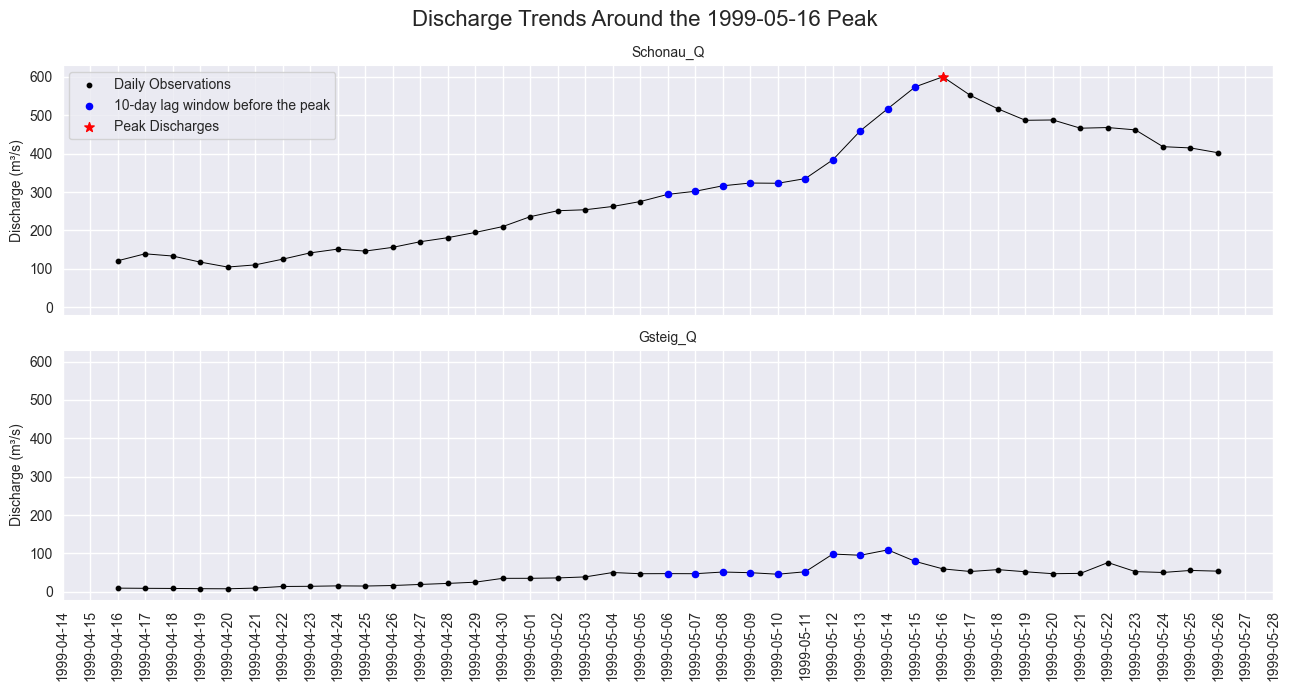

In [17]:
# Define the date range for the 10-day lag window and the peak date
start_date = pd.Timestamp('1999-05-06')
peak_date = pd.Timestamp('1999-05-16')

# Extract single variables
discharge_schonau = tilde_X_1999['Schonau_Q']
discharge_gsteig = tilde_X_1999['Gsteig_Q']
dates = tilde_X_1999.index

# Plot Discharge (1x2) with black dots
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True, sharey=True)

# Schonau Discharge
axes[0].plot(dates, discharge_schonau, color="black", linewidth=0.7)  
axes[0].scatter(dates, discharge_schonau, color="black", s=10, label="Daily Observations")
axes[0].scatter(dates[(dates >= start_date) & (dates < peak_date)],
  discharge_schonau[(dates >= start_date) & (dates < peak_date)],
    color="blue", s=20, marker='o', label="10-day lag window before the peak", zorder=2)
axes[0].scatter(peak_date, discharge_schonau[dates == peak_date], color="red", s=50, marker='*', label="Peak Discharges", zorder=3)
axes[0].set_title("Schonau_Q", fontsize=10)
axes[0].set_ylabel("Discharge (m³/s)")
axes[0].grid(True, linestyle="-", alpha=1, linewidth=1)
axes[0].legend()

# Gsteig Discharge
axes[1].plot(dates, discharge_gsteig, color="black", linewidth=0.7) 
axes[1].scatter(dates, discharge_gsteig, color="black", s=10, label="Daily Observations")
axes[1].scatter(dates[(dates >= start_date) & (dates < peak_date)],
  discharge_gsteig[(dates >= start_date) & (dates < peak_date)],
    color="blue", s=20, marker='o', label="10-day lag window before the peak", zorder=2)
axes[1].set_title("Gsteig_Q", fontsize=10)
axes[1].grid(True, linestyle="-", alpha=1, linewidth=1)
axes[1].set_ylabel("Discharge (m³/s)")

# Formatting X-axis
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=1)) # USED AI
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) # USED AI
plt.xticks(rotation=90)

plt.suptitle("Discharge Trends Around the 1999-05-16 Peak", fontsize=16)
plt.tight_layout()
plt.show()



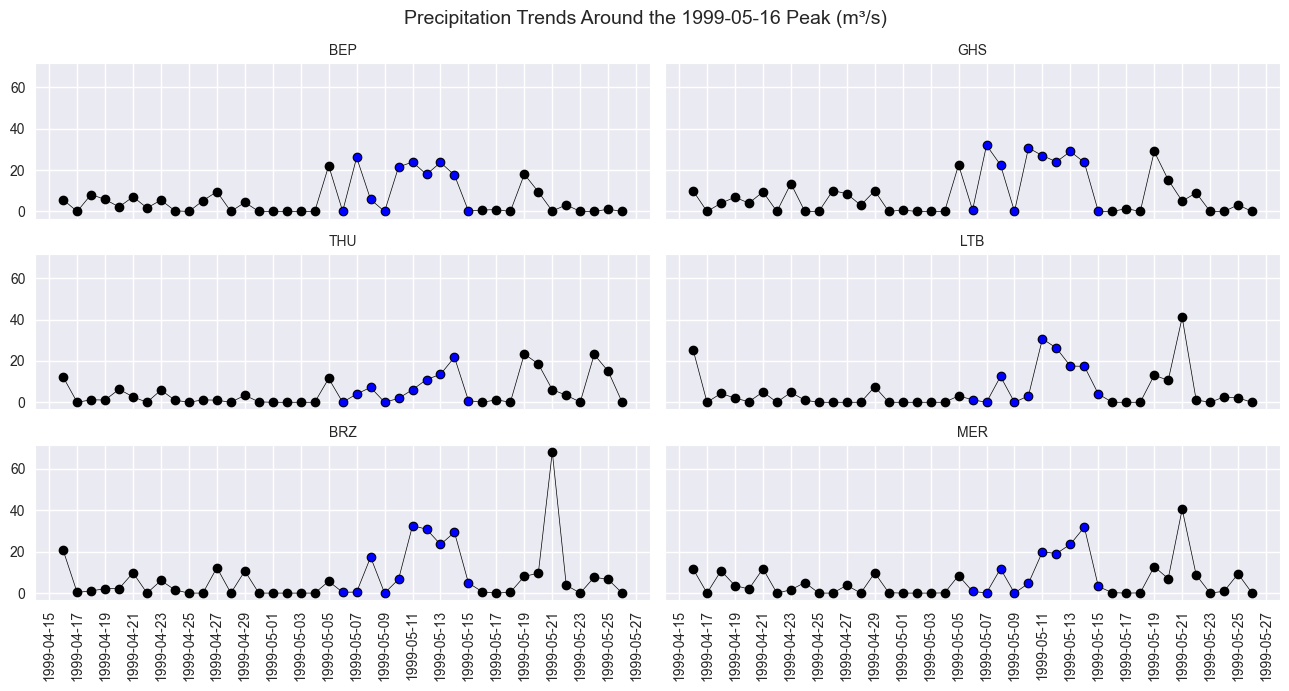

In [18]:
# Plot Precipitation (2x3) 
fig, axes = plt.subplots(3, 2, figsize=(13, 7), sharex=True, sharey=True)

# 10-day lag window before the peak
start_date_P = pd.Timestamp('1999-05-06')
peak_date_P = pd.Timestamp('1999-05-15') 

for ax, station in zip(axes.flatten(), multi_P.columns):
    ax.plot(tilde_X_1999.index, tilde_X_1999[station], color='black', marker='o', linewidth=0.5, label="Daily Observations")
    ax.scatter(tilde_X_1999.loc[start_date_P:peak_date_P].index, tilde_X_1999.loc[start_date_P:peak_date_P, station], 
               color="blue", s=20, marker='o', zorder=2)
    ax.set_title(station, fontsize=10)
    ax.grid(True, linestyle="-", alpha=1, linewidth=1)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.suptitle("Precipitation Trends Around the 1999-05-16 Peak (m³/s)", fontsize=14)
plt.tight_layout()
plt.show()


#### <u>2005 Peak:</u>

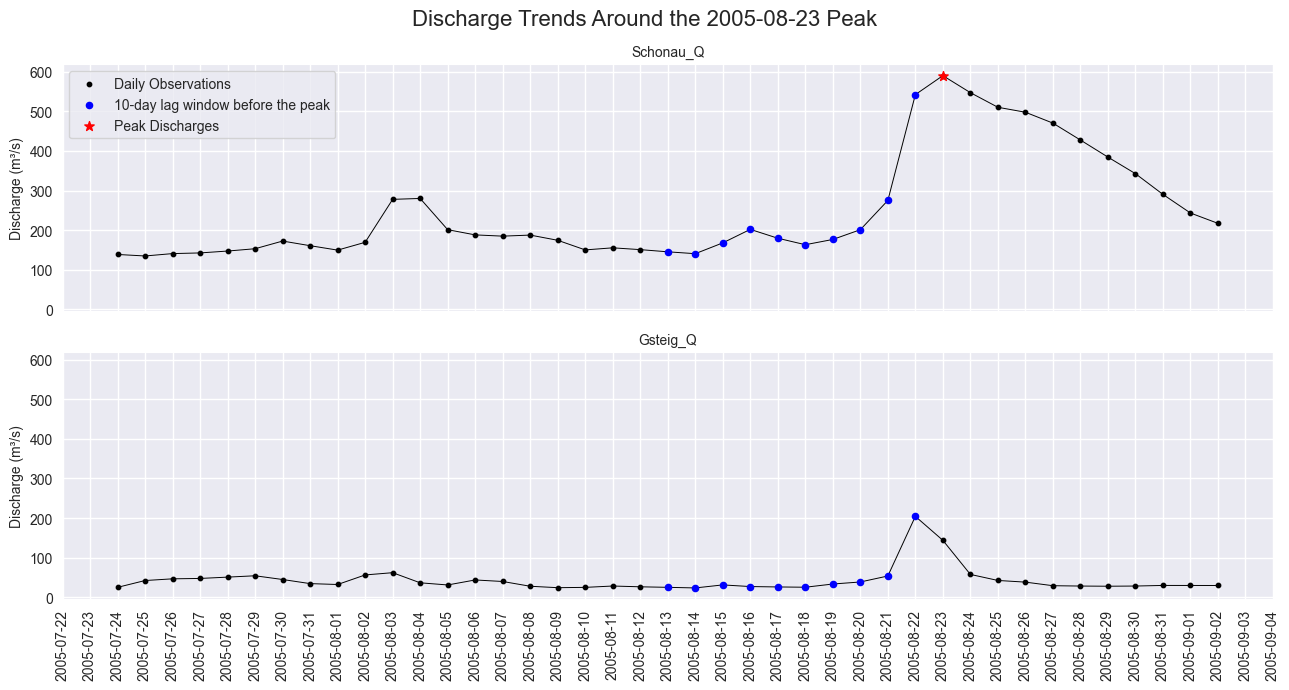

In [19]:
# Define the date range for the 10-day lag window and the peak date
start_date = pd.Timestamp('2005-08-13')
peak_date = pd.Timestamp('2005-08-23')

# Extract single variables
discharge_schonau = tilde_X_2005['Schonau_Q']
discharge_gsteig = tilde_X_2005['Gsteig_Q']
dates = tilde_X_2005.index

# Plot Discharge (1x2) with black dots
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True, sharey=True)

# Schonau Discharge
axes[0].plot(dates, discharge_schonau, color="black", linewidth=0.7)  # Add line plot
axes[0].scatter(dates, discharge_schonau, color="black", s=10, label="Daily Observations")
axes[0].scatter(dates[(dates >= start_date) & (dates < peak_date)],
     discharge_schonau[(dates >= start_date) & (dates < peak_date)],
       color="blue", s=20, marker='o', label="10-day lag window before the peak", zorder=2)
axes[0].scatter(peak_date, discharge_schonau[dates == peak_date], color="red", s=50, marker='*', label="Peak Discharges", zorder=3)
axes[0].set_title("Schonau_Q", fontsize=10)
axes[0].set_ylabel("Discharge (m³/s)")
axes[0].grid(True, linestyle="-", alpha=1, linewidth=1)
axes[0].legend()

# Gsteig Discharge
axes[1].plot(dates, discharge_gsteig, color="black", linewidth=0.7)  # Add line plot
axes[1].scatter(dates, discharge_gsteig, color="black", s=10, label="Daily Observations")
axes[1].scatter(dates[(dates >= start_date) & (dates < peak_date)],
     discharge_gsteig[(dates >= start_date) & (dates < peak_date)],
       color="blue", s=20, marker='o', label="10-day lag window before the peak", zorder=2)
axes[1].set_title("Gsteig_Q", fontsize=10)
axes[1].grid(True, linestyle="-", alpha=1, linewidth=1)
axes[1].set_ylabel("Discharge (m³/s)")

# Formatting X-axis
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=90)

plt.suptitle("Discharge Trends Around the 2005-08-23 Peak", fontsize=16)
plt.tight_layout()
plt.show()


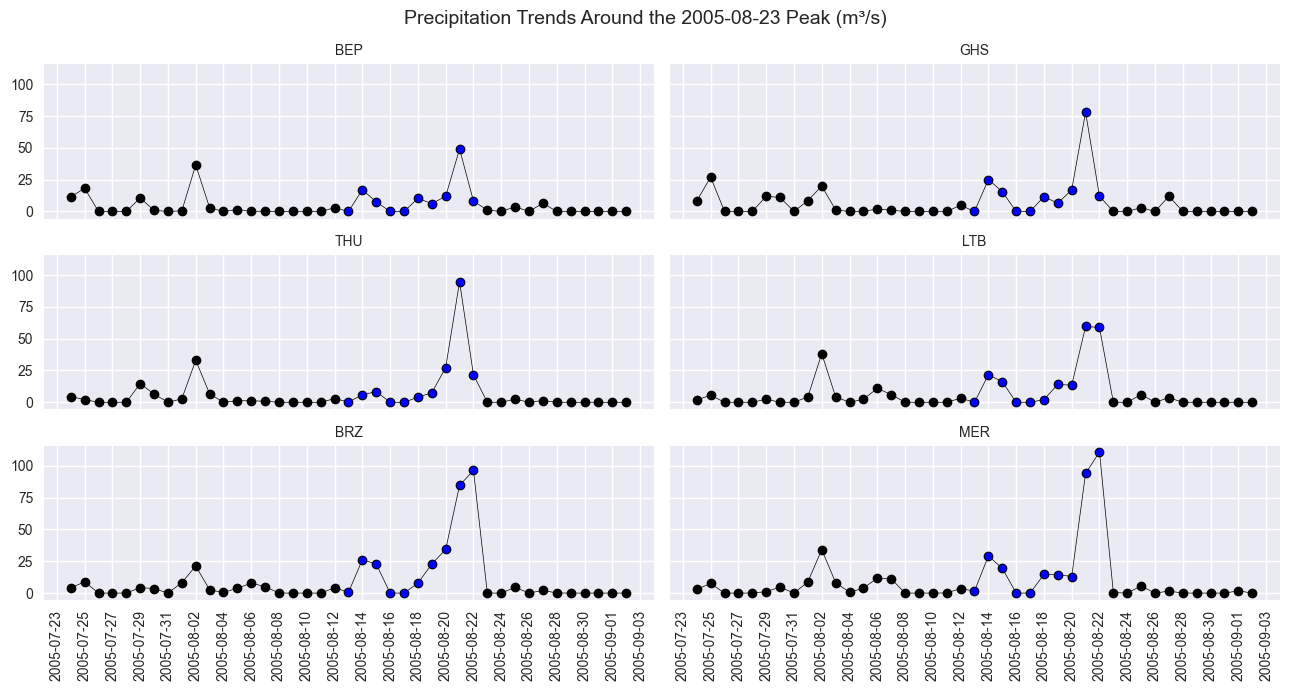

In [20]:
# Plot Precipitation (2x3) 
fig, axes = plt.subplots(3, 2, figsize=(13, 7), sharex=True, sharey=True)

# 10 lags before 2005-08-23 
start_date_P = pd.Timestamp('2005-08-13') 
peak_date_P = pd.Timestamp('2005-08-22')   

for ax, station in zip(axes.flatten(), multi_P.columns):
    ax.plot(tilde_X_2005.index, tilde_X_2005[station], color='black', linewidth=0.5, marker='o', label="Daily Observations")
    ax.scatter(tilde_X_2005.loc[start_date_P:peak_date_P].index, tilde_X_2005.loc[start_date_P:peak_date_P, station], 
               color="blue", s=20, marker='o', zorder=3)
    ax.set_title(station, fontsize=10)
    ax.grid(True, linestyle="-", alpha=1, linewidth=1)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.suptitle("Precipitation Trends Around the 2005-08-23 Peak (m³/s)", fontsize=14)
plt.tight_layout()
plt.show()


**Comment:**

In both peak scenarios, each set of variables offers interesting insights into the previous window before the peak. While this is expected, given that these natural events are caused by high precipitation and rising water levels from upstream locations in terms of water affluence, it still provides a good indication that using spatial information across the region can help build a model with impactful predictive power for discharge at the Bern-Schönau station.

For this reason, sequential time values are validated as a suitable approach for a model that predicts the next day's discharge based on a combination of variables that significantly explain the rise in the response variable.

## 03. <u> Further time series analysis</u>

In [21]:
tilde_X

Gsteig_Q  BEP  GHS  THU   LTB   BRZ  MER  Schonau_Q
Date                                                           
1930-01-01     3.600  0.0  0.0  0.0   0.8   1.3  0.5     46.100
1930-01-02     3.600  3.2  0.5  2.3   1.0   3.4  3.2     46.100
1930-01-03     3.500  0.0  0.0  0.0   0.0   0.0  0.0     67.800
1930-01-04     3.400  0.0  0.0  0.0   0.0   0.0  0.0     57.900
1930-01-05     3.220  0.0  0.0  0.0   0.0   0.0  0.0     42.400
...              ...  ...  ...  ...   ...   ...  ...        ...
2014-12-27     4.349  3.8  5.2  3.9  15.2  19.4  4.2     48.716
2014-12-28     4.391  0.9  0.5  1.8   1.8   1.0  1.9     48.370
2014-12-29     3.999  3.5  9.6  6.4   6.1   6.0  6.7     46.835
2014-12-30     4.061  1.6  2.6  2.3   2.7   3.0  2.7     44.834
2014-12-31     4.024  0.0  0.0  0.0   0.0   0.0  0.0     44.774

[31046 rows x 8 columns]

Text(0.5, 1.0, 'Discharge Over Time at Schonau')

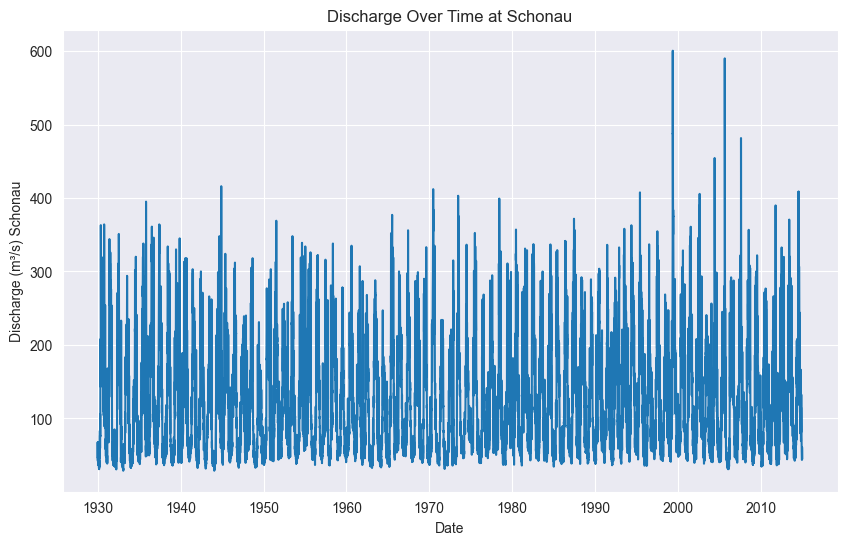

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=tilde_X, x=tilde_X.index, y='Schonau_Q')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s) Schonau')
plt.title('Discharge Over Time at Schonau')

<Figure size 1200x1200 with 0 Axes>

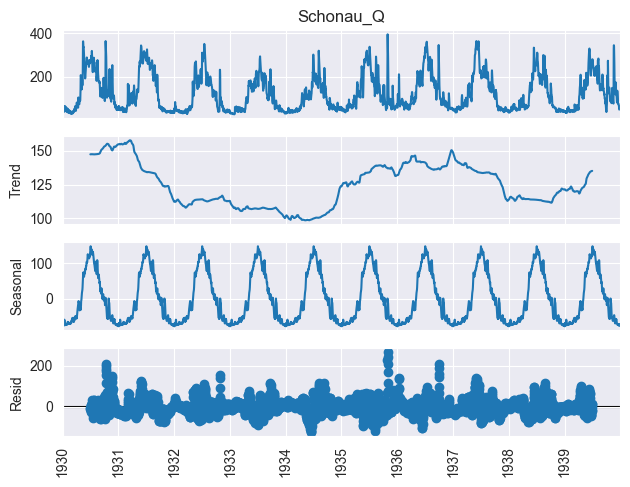

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12, 12))
# first 10 years of data for seasonal decomposition
result = seasonal_decompose(tilde_X['Schonau_Q'][:3650], model='additive', period=365)
result.plot()
plt.xticks(rotation=90)
plt.show()

### <u>ADF test</u>

The Dickey-Fuller test is used to assess stationarity under the null hypothesis that the time series is non-stationary.
Given the very small p-value, we can reject the null hypothesis and conclude that the discharge series is likely stationary over time.

In [24]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tilde_X['Schonau_Q'][:10000])
print(f"p-value test: {adf_test[1]}")

p-value test: 2.677756200783862e-11


### <u>Cross-correlation plot</u>
To observe the correlation between lagged covariates and the response variable, we can use a cross-correlation plot. This helps identify which lags of the covariates are most strongly correlated with the response, providing insight into which time-shifted features may be important for the predictive task.

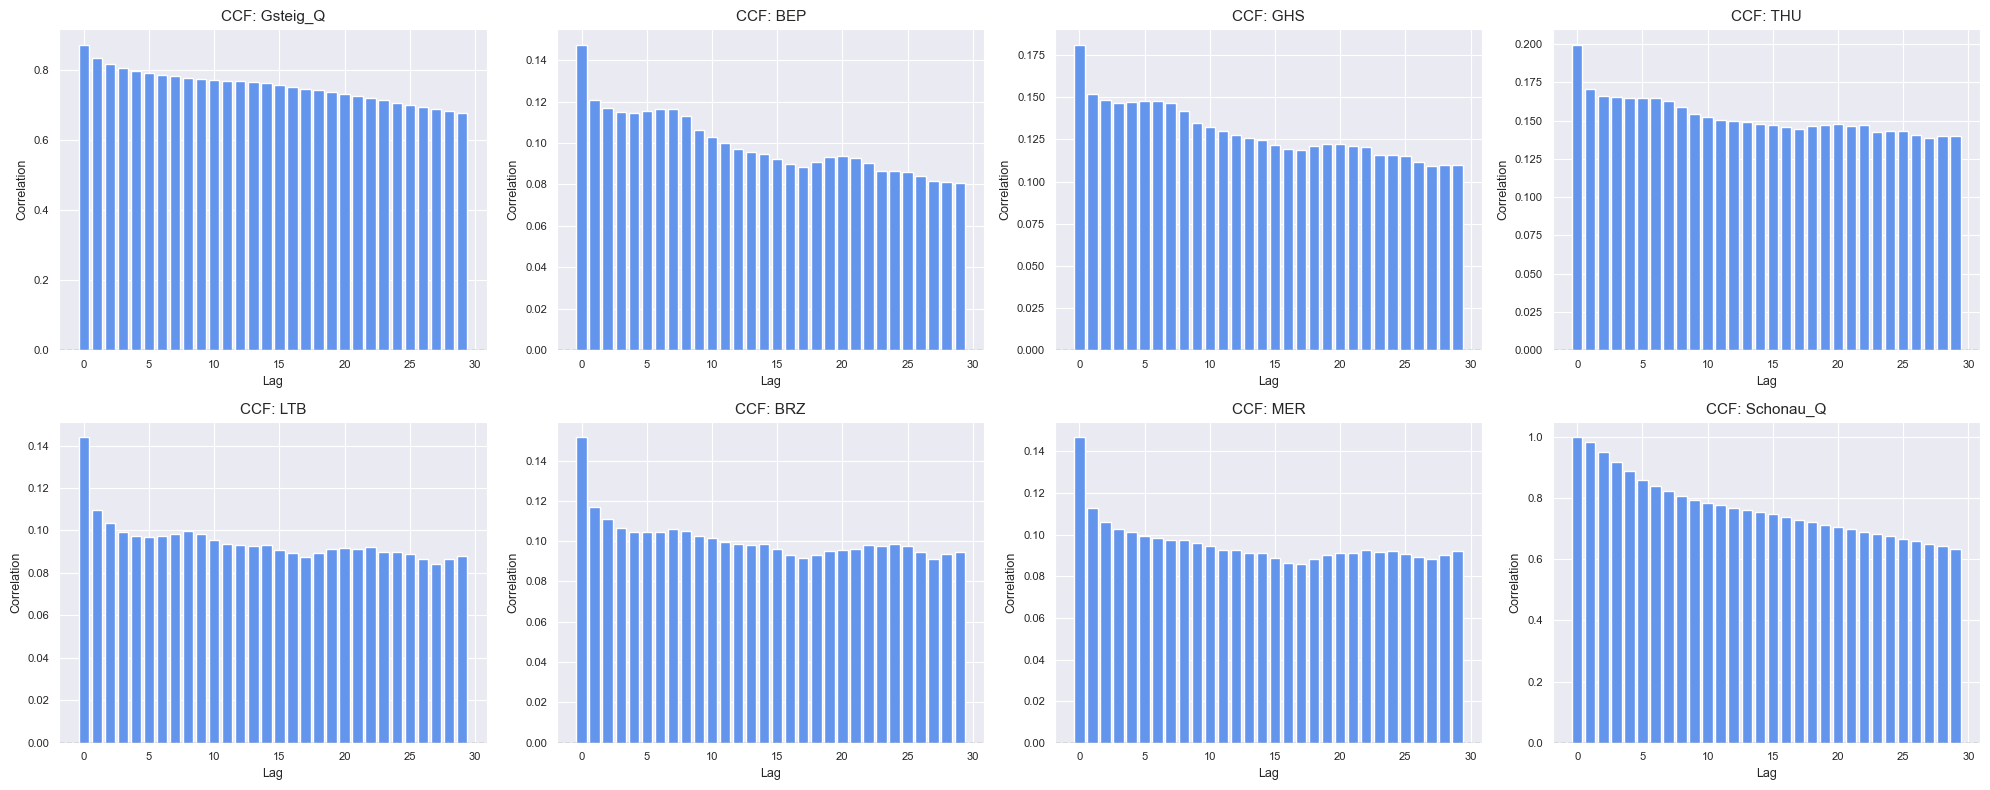

In [25]:
from statsmodels.tsa.stattools import ccf
import math


y = tilde_X['Schonau_Q'][:10000]
x = tilde_X[:10000]

ccf_results = {}
for col in x.columns:
    ccf_values = ccf(x[col], y, adjusted=False)[:30]
    ccf_results[col] = ccf_values


n_vars = len(ccf_results)
n_cols = 4
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, (col, values) in enumerate(ccf_results.items()):
    axes[i].bar(range(len(values)), values, color='cornflowerblue')
    axes[i].set_title(f"CCF: {col}", fontsize=11)
    axes[i].set_xlabel("Lag", fontsize=9)
    axes[i].set_ylabel("Correlation", fontsize=9)
    axes[i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axes[i].tick_params(axis='both', labelsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### <u>Interpolation and extrapolation</u>

In [26]:
# Find max value in the training set
split = int(len(tilde_X)*0.335)
max_value = tilde_X['Schonau_Q'][:split].max()
print(f"Maximum value in the training set: {max_value}")

# Find how many extrapolated values are above the maximum value in the test set
above_max = (tilde_X['Schonau_Q'][split:] > max_value).sum()
print(f"Number of test values above the maximum value in the training set: {above_max}") 

Maximum value in the training set: 416.0
Number of test values above the maximum value in the training set: 23


In [27]:
# Find max value in the training set
split = int(len(tilde_X)*0.335)
max_value = tilde_X['Schonau_Q'][:split].quantile(0.995)
above_max_train = (tilde_X['Schonau_Q'][:split] > max_value).sum()
print(f"Number of training values above the 99.5% quantile: {above_max_train}")
print(f"Maximum value in the training set: {max_value}")

# Find how many extrapolated values are above the maximum value in the test set
above_max = (tilde_X['Schonau_Q'][split:] > max_value).sum()
print(f"Number of test values above the maximum value in the training set: {above_max}") 

Number of training values above the 99.5% quantile: 50
Maximum value in the training set: 338.0
Number of test values above the maximum value in the training set: 167


### <u>Heteroskedasticity of the time series </u>
-  #### <u>**Monthly Rolling standard deviation**</U>

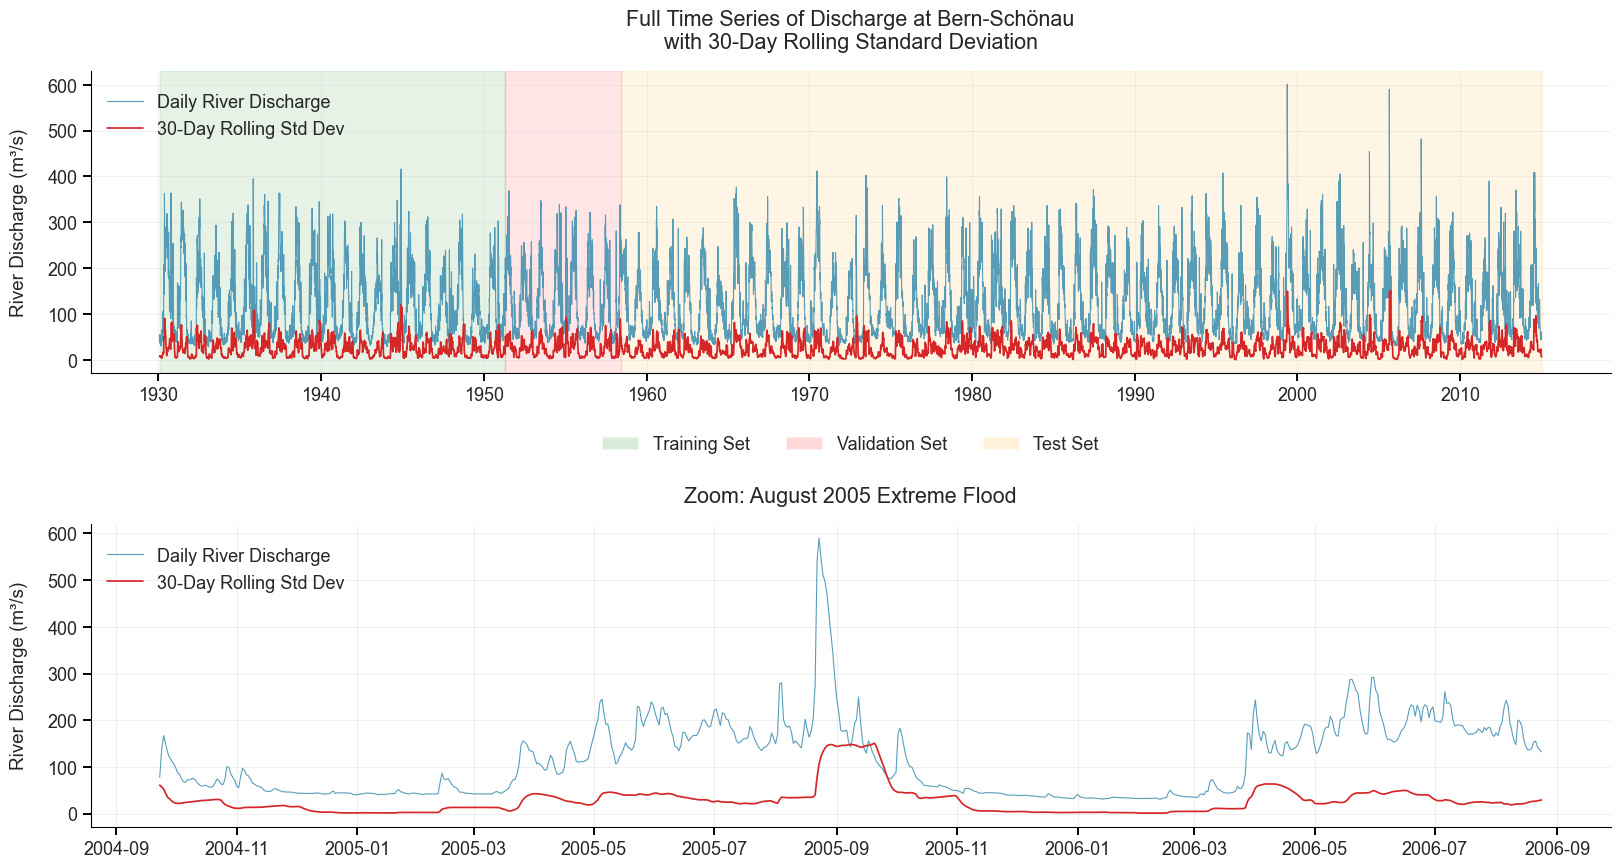

In [29]:
# Prepare series
y_full = tilde_X['Schonau_Q']
y_3years = y_full[int(365 * 74.7):int(365 * 76.7)]  
rolling_full = y_full.rolling(window=30).std()
rolling_3years = y_3years.rolling(window=30).std()

# Define split indices
train_end = 7761
val_end = 10349

# Layout setup
fig, axes = plt.subplots(2, 1, figsize=(16, 9))
fig.subplots_adjust(hspace=0.5, left=0.025, right=0.975, top=0.92, bottom=0.08)

# Full series plot
valid_start_full = rolling_full.first_valid_index()
y_full_aligned = y_full[valid_start_full:]
rolling_full_aligned = rolling_full[valid_start_full:]

axes[0].axvspan(y_full_aligned.index[0], y_full_aligned.index[min(train_end, len(y_full_aligned)-1)], 
                alpha=0.1, color='green', zorder=0)
axes[0].axvspan(y_full_aligned.index[min(train_end, len(y_full_aligned)-1)], 
                y_full_aligned.index[min(val_end, len(y_full_aligned)-1)], 
                alpha=0.1, color='red', zorder=0)
if val_end < len(y_full_aligned):
    axes[0].axvspan(y_full_aligned.index[val_end], y_full_aligned.index[-1], 
                    alpha=0.1, color='orange', zorder=0)

axes[0].plot(y_full_aligned.index, y_full_aligned, label='Daily River Discharge', 
             color='#2E86AB', linewidth=0.8, alpha=0.8)
axes[0].plot(rolling_full_aligned.index, rolling_full_aligned, label='30-Day Rolling Std Dev', 
             color='#D62728', linewidth=1.25)
axes[0].set_title('Full Time Series of Discharge at Bern-Schönau\nwith 30-Day Rolling Standard Deviation', 
                  fontsize=15.5, pad=16)
axes[0].set_ylabel('River Discharge (m³/s)', fontsize=13.5, labelpad=14)
axes[0].grid(True, color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)  
axes[0].set_facecolor('white')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_color('black')
axes[0].spines['left'].set_color('black')
axes[0].legend(frameon=False, fontsize=13, bbox_to_anchor=(0.0, 0.98), 
               loc='upper left')

axes[0].xaxis.set_major_locator(YearLocator(10))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Split legend
split_legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.15, label='Training Set'),
    plt.Rectangle((0, 0), 1, 1, facecolor='red', alpha=0.15, label='Validation Set'),
    plt.Rectangle((0, 0), 1, 1, facecolor='orange', alpha=0.15, label='Test Set')
]
fig.legend(handles=split_legend_elements, loc='center', 
           bbox_to_anchor=(0.5, 0.505), ncol=3, frameon=False, fontsize=13)

# Event plot
valid_start_3y = rolling_3years.first_valid_index()
y_3years_aligned = y_3years[valid_start_3y:]
rolling_3years_aligned = rolling_3years[valid_start_3y:]

axes[1].plot(y_3years_aligned.index, y_3years_aligned, label='Daily River Discharge', 
             color='#2E86AB', linewidth=0.8, alpha=0.8)
axes[1].plot(rolling_3years_aligned.index, rolling_3years_aligned, label='30-Day Rolling Std Dev', 
             color='#D62728', linewidth=1.25)
axes[1].set_title('Zoom: August 2005 Extreme Flood', fontsize=15.5, pad=16)
axes[1].set_ylabel('River Discharge (m³/s)', fontsize=13.5, labelpad=14)
axes[1].grid(True, color='lightgray', linewidth=0.5, alpha=0.5, zorder=1) 
axes[1].set_facecolor('white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_color('black')
axes[1].spines['left'].set_color('black')
axes[1].legend(frameon=False, fontsize=13, bbox_to_anchor=(0.0, 0.98), 
               loc='upper left')

axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


# Apply tick styling
for ax in axes:
    ax.tick_params(axis='x', which='major', bottom=True, top=False, 
                   length=6, width=1.4, color='black', labelsize=13)
    ax.tick_params(axis='y', which='major', left=True, right=False,
                   length=6, width=1.4, color='black', labelsize=13)

plt.savefig('rolling_std.png', bbox_inches='tight', dpi=600)
plt.show()